In [1]:
import torch
import torch.nn as nn
import random
import numpy as np
import pandas as pd
import json
import cv2
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from functools import partial
from dataclasses import dataclass
from collections import OrderedDict
import torchvision
from IPython.display import clear_output
import matplotlib.pyplot as plt
import tqdm
from PIL import ImageFilter, Image
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import math
#import torch.utils.model_zoo as model_zoo
from torch.nn import init

from network.meso import Meso4, MesoInception4
from network.models import model_selection, return_pytorch04_xception
from network.lstm_deepfake import LSTMDF
 
from pipeline.metrics import accuracy, log_loss, accuracy_b, log_loss_b
from pipeline.model_methods import validate_img, train_img, validate_vid, train_vid
from pipeline.data_loaders import load_img_dataset
from pipeline.image_extracting import extract_faces, FastMTCNN


random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
PATH = "model.h5"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

d:\users\user\appdata\local\programs\python\python36\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
d:\users\user\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
d:\users\user\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
y_train = pd.read_csv('data\\frames\\metadata.csv')
len(y_train[y_train.label == 1]), len(y_train[y_train.label == 0])

(94949, 18265)

In [3]:
batch_size = 1
limit = 1
x_train = r'D:\Machine Learning\deepfake-detection\data\train_set'
x_val = r'D:\Machine Learning\deepfake-detection\data\validation_set'

In [4]:
%%script false

model = return_pytorch04_xception()

#for param in model.parameters():
#    model.requires_grad = False

#in_features = model.fc.in_features
model.last_linear = nn.Sequential(
            nn.LSTM(2048, 512, 2, dropout=0.5),
            nn.Dropout(0.5),
            nn.Linear(512, 2)
        )

Couldn't find program: 'false'


In [5]:
%%script false

model_path = r'faceforensics++_models_subset\face_detection\xception\all_c40.p'
model = torch.load(model_path)
torch.save(model.state_dict(), "all_c40.pth")

Couldn't find program: 'false'


In [6]:
model, *_ = model_selection(modelname='xception', num_out_classes=2, dropout=None)
#model = Meso4() #LSTMDF(dropout=0.5)
loss =  torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [7]:
%%script false
model.load_state_dict(torch.load('pretrained/best.pkl'))

if isinstance(model, torch.nn.DataParallel):
    model = model.module

Couldn't find program: 'false'


In [8]:
#%%script false

model.load_state_dict(torch.load("pretrained/xception/all_c40.pth"))
model.eval()

TransferModel(
  (model): Xception(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (block1): Block(
      (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (rep): Sequential(
        (0): SeparableConv2d(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
    

In [9]:
model = model.to(device)

In [14]:
fast_mtcnn = FastMTCNN(
    stride=4,
    resize=1,
    margin=14,
    factor=0.6,
    keep_all=False,
    select_largest=False,
    device=device
)
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
    #torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [15]:
#%%script false
'''
4 1 14 0.6 false false 20 5 0.99      | Validation: metrics  0.6666666666666666 loss  0.65966153
4 1 14 0.6 false false 30 5 0.99      | Validation: metrics  0.6682242990654206 loss  0.6598151
'''

validate_vid(model, x_val, y_train, loss, accuracy_b, device, 30, fast_mtcnn, transforms,
             print_results=True, 
             inference=nn.Softmax(dim=1), delimeter=5)

0.0001 tensor(0, device='cuda:0')
0.9001 tensor(0, device='cuda:0')
0.9808692307692307 tensor(0, device='cuda:0')
0.23343333333333333 tensor(0, device='cuda:0')
0.9334333333333333 tensor(0, device='cuda:0')
1.0001 tensor(0, device='cuda:0')
0.14295714285714284 tensor(0, device='cuda:0')
1.0001 tensor(0, device='cuda:0')
0.5626 tensor(0, device='cuda:0')
0.7667666666666667 tensor(0, device='cuda:0')
0.7667666666666667 tensor(0, device='cuda:0')
0.9001 tensor(0, device='cuda:0')
1.0001 tensor(0, device='cuda:0')
0.033433333333333336 tensor(0, device='cuda:0')
0.0001 tensor(0, device='cuda:0')
0.43343333333333334 tensor(0, device='cuda:0')
0.14715882352941176 tensor(0, device='cuda:0')
0.8001 tensor(0, device='cuda:0')
0.2001 tensor(0, device='cuda:0')
1.0001 tensor(0, device='cuda:0')
0.6251 tensor(0, device='cuda:0')
1.0001 tensor(0, device='cuda:0')
1.0001 tensor(0, device='cuda:0')
0.8824529411764706 tensor(0, device='cuda:0')
0.09533809523809524 tensor(0, device='cuda:0')
0.5001 tens

1.0001 tensor(1, device='cuda:0')
0.8334333333333334 tensor(1, device='cuda:0')
0.11774705882352941 tensor(1, device='cuda:0')
1.0001 tensor(1, device='cuda:0')
0.0001 tensor(1, device='cuda:0')
0.4643857142857143 tensor(1, device='cuda:0')
0.16676666666666665 tensor(1, device='cuda:0')
1.0001 tensor(1, device='cuda:0')
1.0001 tensor(1, device='cuda:0')
0.0001 tensor(1, device='cuda:0')
0.21062631578947366 tensor(1, device='cuda:0')
0.6667666666666666 tensor(1, device='cuda:0')
0.4697969696969697 tensor(1, device='cuda:0')
0.0001 tensor(1, device='cuda:0')
0.7501 tensor(1, device='cuda:0')

Validation: metrics  0.6502242152466368 loss  0.66510624


(0.6502242152466368, 0.66510624)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


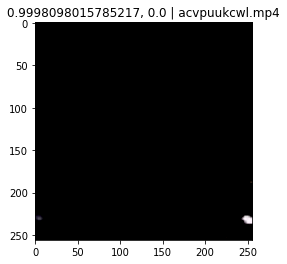

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


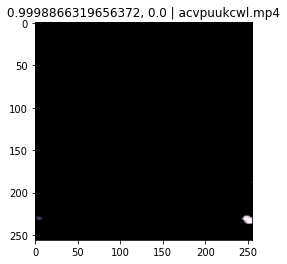

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


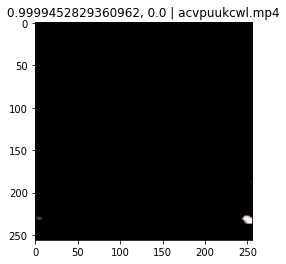

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


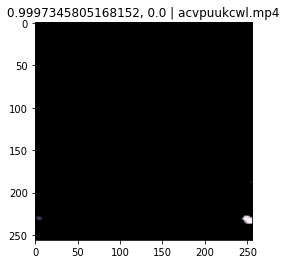

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


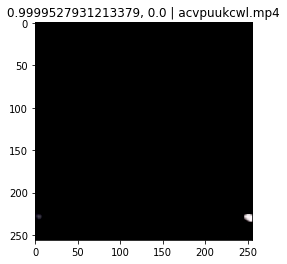

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


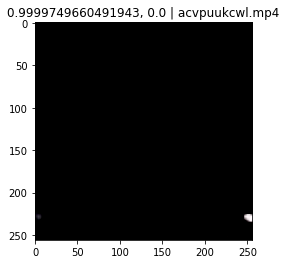

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


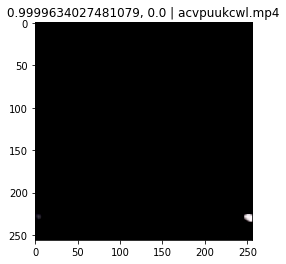

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


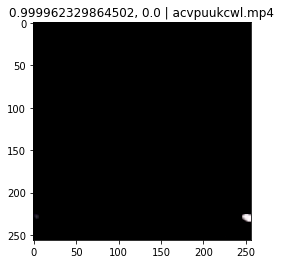

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


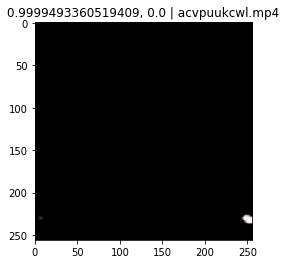

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


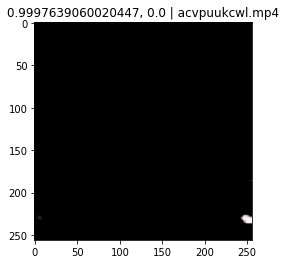

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


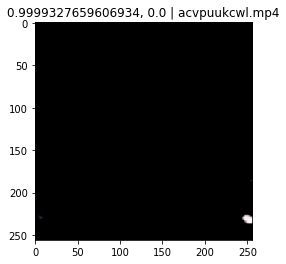

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


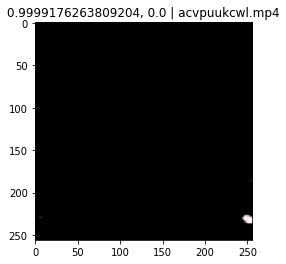

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


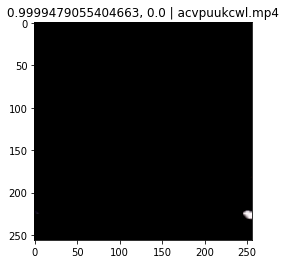

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


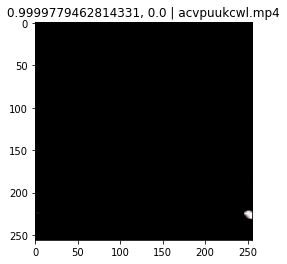

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


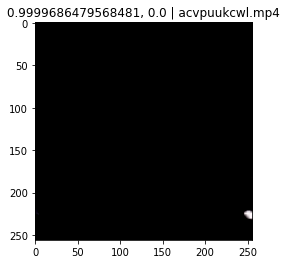

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


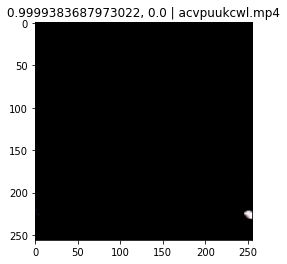

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


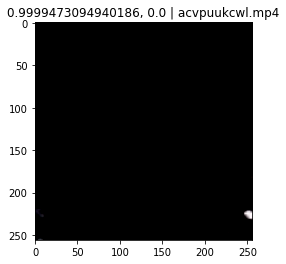

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


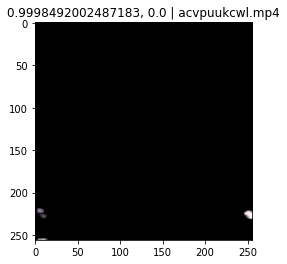

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


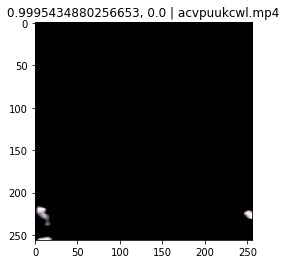

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


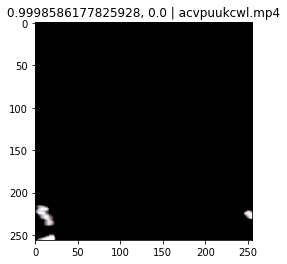

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


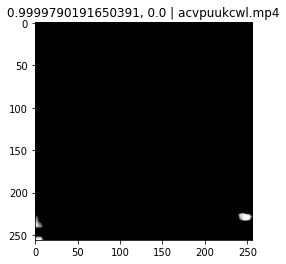

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


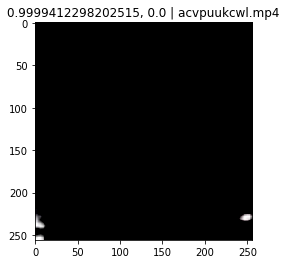

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


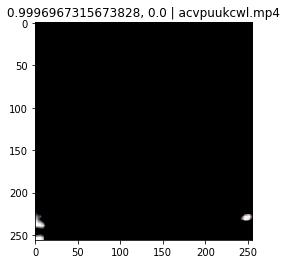

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


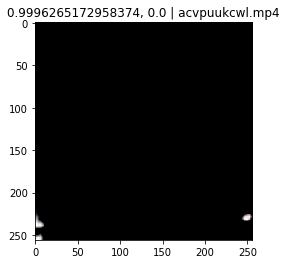

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


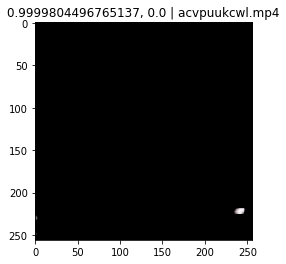

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


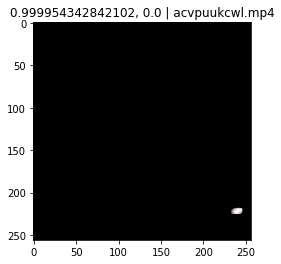

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


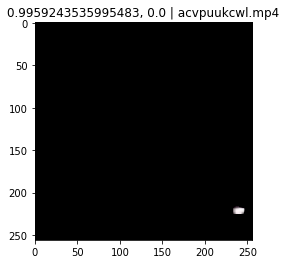

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


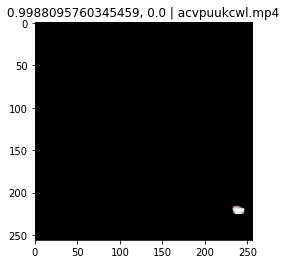

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


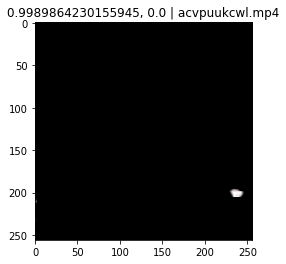

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


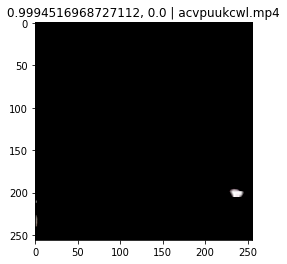

KeyboardInterrupt: 

In [12]:
validate_vid(model, x_val, y_train, loss, accuracy_b, device, 30, fast_mtcnn, transforms, 
             show_results=True, inference=nn.Softmax(dim=1), delimeter=5)

In [ ]:
# FFInception 256x256 0.5 | Validation: metrics  75.0 loss  0.6236956

In [ ]:
metric, lost = trai1n_vid(model, loss, optimizer, scheduler, x_train, x_val, y_train, accuracy_b, device, fast_mtcnn, 
                         transforms, 
                         epochs=15, 
                         batch_size=batch_size, 
                         del_net=False, 
                         useInference=False,
                         inference=nn.Softmax(dim=1), 
                         useScheduler=True,
                         checkpoint=60,
                         limit=limit
                      )

In [ ]:
from operator import itemgetter
min_lost = min(enumerate(lost), key=itemgetter(1))[0] 
min_metrics = min(enumerate(metric), key=itemgetter(1))[0] 
print("Loss optim:", lost[min_lost], min_lost + 1)
print("Metrics optim:", metric[min_metrics], min_metrics + 1)

In [ ]:
plt.plot(metric, label='model')
plt.legend()
plt.title('Validation metrics')

In [ ]:
plt.plot(lost, label='model')
plt.legend()
plt.title('Validation Loss')

In [ ]:
'''model = torch.load(PATH)
model = model.to(device)
model.eval()'''

In [ ]:
validate_vid(model, x_val, y_train, loss, log_loss, device, 30, fast_mtcnn, transforms, print_results=True, inference=nn.Softmax(dim=1), delimeter=5)

In [ ]:
validate_vid(model, x_val, y_train, loss, log_loss, device, 30, fast_mtcnn, transforms, show_results=True, inference=nn.Softmax(dim=1), delimeter=5)

In [ ]:
validate_vid(model, x_val, y_train, loss, log_loss, device, 30, fast_mtcnn, transforms, show_graphic=True, inference=nn.Softmax(dim=1), delimeter=5)

In [ ]:
#torch.save(model, PATH)